# Introduction  
This is the Future Sales competition. The aim is to predict monthly sales of items in specific shops, given historical data. The sale counts are clipped between 0 and 20.


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Load Data

In [2]:
df1 = pd.read_csv('data/items.csv')
len(df1.item_name.unique()) 
df1.info()
print('unique names:', len(df1.item_name.unique()))
print('unique categories: ', len(df1.item_category_id.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
unique names: 22170
unique categories:  84


So we've got 22170 unique items and they are devived into 84 categories

In [3]:
df2 = pd.read_csv('data/sales_train.csv')
df2.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
df3 = pd.read_csv('data/shops.csv')
print(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
df4 = pd.read_csv('data/item_categories.csv')
print(df4.info())
df4.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
None


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [242]:
df5 = pd.read_csv('data/test.csv')
len(df5.item_id.unique()) 

5100

# Data Cleaning

###   Remove Outliers

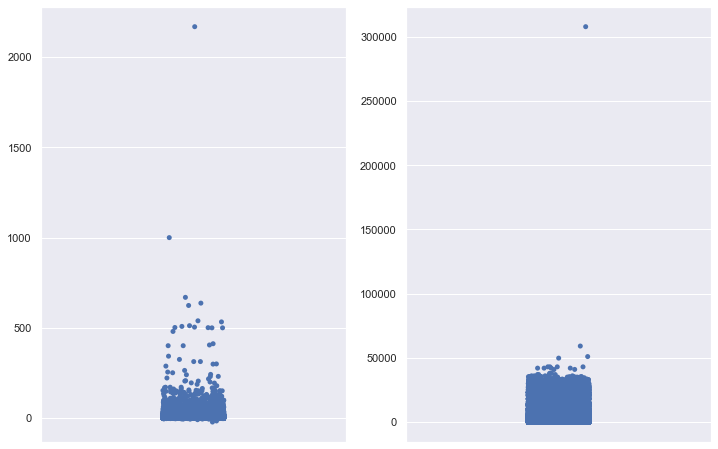

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
sns.stripplot(df2[['item_cnt_day']], orient = 'v', ax = axs[0])
sns.stripplot(df2[['item_price']], orient = 'v', ax=axs[1]);

We'll remove outliers in the dataset - item_cnt_day < 1000 and tem_price < 300000. Also remove rows that have item_cnt_day < 0.

In [8]:
df2 = df2[(df2.item_cnt_day < 1000) & (df2.item_cnt_day > 0) &(df2.item_price < 300000)].reset_index(drop=True)

### Cleaning Shop Data

Add column city

In [9]:
df3['city'] = df3.shop_name.apply(lambda x: x.split(' ')[0])
df3.iloc[0:2, 2] = 'Якутск'

In [10]:
from sklearn.preprocessing import LabelEncoder

df3.city = LabelEncoder().fit_transform(df3.city)
df3.drop('shop_name', axis=1, inplace=True)

### Cleaninig Item Category Data

Add column type whith stadns for type of product

In [11]:
def func(x):
    categories = ['Карты', 'Аксессуары', 'Билеты', 'Доставка', 'консоли', 'Игры', 'Кино', 'Книги', 
    'Музыка', 'Подарки', 'Программы', 'Служебные', 'носители', 'Элементы']
    for cat in categories:
        if x.find(cat) != -1:
            return cat
    return 'etc'

In [12]:
df4.head()
df4['item_type_id'] = df4.item_category_name.apply(func)
df4[df4['item_type_id'] == 'etc']

,item_category_name,item_category_id,item_type_id
0,PC - Гарнитуры/Наушники,0,etc


In [13]:
df4[df4['item_type_id'] == 'etc']['item_type_id'] = 'Аксессуары'

df4.item_type_id = LabelEncoder().fit_transform(df4.item_type_id);

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Preprocessing


Create a matrix df with every combination of month, shop and item.

In [85]:
from itertools import product

grid = []
cols = ['date_block_num', 'shop_id', 'item_id']

for i in range(34):
        sales = df2[df2.date_block_num == i]
        grid.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype=np.int16))

grid = pd.DataFrame(np.vstack(grid), columns = cols)

Add column *item_cnt_month*. It stands for amount of items sold per month

In [86]:
group = df2.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day' : 'sum'})
group.columns = ['itemshop_cnt_month']
group.reset_index(inplace=True)

grid = grid.merge(group, on = ['date_block_num', 'shop_id', 'item_id'], how='left')
grid.itemshop_cnt_month.fillna(0, inplace=True)

Add test data

In [87]:
grid = pd.concat([grid, df5[['shop_id' ,'item_id']]])
grid.date_block_num.fillna(34, inplace=True)

### Idea 0: Add some fitures: city id, item category, item type.

In [88]:
grid = grid.merge(df3[['shop_id', 'city']], on = 'shop_id')
grid = grid.merge(df1[['item_id', 'item_category_id']], on='item_id')
grid = grid.merge(df4[['item_category_id', 'item_type_id']], on='item_category_id')

### Idea 1: Add colunm *itemshop_cnt_month_lag_i*. It stands for  amount of items sold per last(pre-previous) month in spesific shop.

In [89]:
def lag_feature( df,lags, col):
    shifted = df[["date_block_num", "shop_id","item_id",col]].copy()
    for i in lags:
        shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
        shifted.date_block_num += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col + "_lag_"+str(i)] = df[col + "_lag_"+str(i)].fillna(0)       
    return df

In [90]:
grid = lag_feature(grid, [1, 2, 3], 'itemshop_cnt_month')

In [91]:
grid.head()

,date_block_num,shop_id,item_id,itemshop_cnt_month,city,item_category_id,item_type_id,itemshop_cnt_month_lag_1,itemshop_cnt_month_lag_2,itemshop_cnt_month_lag_3
0,0.0,59,22154,1.0,30,37,6,0.0,0.0,0.0
1,1.0,59,22154,0.0,30,37,6,1.0,0.0,0.0
2,2.0,59,22154,0.0,30,37,6,0.0,0.0,0.0
3,3.0,59,22154,0.0,30,37,6,0.0,1.0,0.0
4,7.0,59,22154,0.0,30,37,6,0.0,0.0,0.0


### Idea 2: Add column *item_cnt_month*. It statnds for amount of items sold per last(pre-previos) month.

In [92]:
groups = grid.groupby(['date_block_num', 'item_id']).agg({'itemshop_cnt_month': 'mean'})
groups.columns = ['item_cnt_month']
grid = grid.merge(groups, on=['date_block_num', 'item_id'], how='left')
grid.item_cnt_month = grid.item_cnt_month.fillna(0)

In [93]:
grid = lag_feature(grid, [1, 2, 3], 'item_cnt_month')

### Idea 3: Add previous shop/item price as feature
* Add column *item_avg_price*. It standa for average price of item for entire period
* Add column *item_avg_price_month*. It stands for average price of a specific product for a month
* Add lags columns - *item_avg_price_month_lag_i*
* Add column *delta_price*. $\frac{item\_avg\_price\ -\ item\_avg\_price\_month\_lag\_i}{item\_avg\_price}$

In [94]:
group = df2.groupby(['item_id']).agg({'item_price': 'mean'})
group.columns = ['item_avg_price'] 
group.reset_index(inplace = True)
grid = grid.merge(group, on = ['item_id'], how = 'left')

In [95]:
group = df2.groupby(['date_block_num', 'item_id']).agg({'item_price': 'mean'})
group.columns = ['item_avg_price_month']
group.reset_index(inplace=True)
grid = grid.merge(group, on =['date_block_num', 'item_id'], how='left')

In [96]:
grid = lag_feature(grid, [1, 2, 3], 'item_avg_price_month')

In [97]:
def select(row):
    for i in range(1, 4):
        if not pd.isna(row['item_avg_price_month_lag_'+str(i)]):
            return (row['item_avg_price'] - row['item_avg_price_month_lag_'+str(i)]) / row['item_avg_price']
    return 0

In [98]:
import time
ts = time.time()
grid['delta_price_lag_1'] = grid.apply(select, axis=1)
time.time() - ts

522.4245941638947

### Idea 4: Add number of month as feature.

In [99]:
grid['month'] = grid['date_block_num'] % 12

In [100]:
 grid.columns

Index(['date_block_num', 'shop_id', 'item_id', 'itemshop_cnt_month', 'city',
       'item_category_id', 'item_type_id', 'itemshop_cnt_month_lag_1',
       'itemshop_cnt_month_lag_2', 'itemshop_cnt_month_lag_3',
       'item_cnt_month', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_avg_price', 'item_avg_price_month',
       'item_avg_price_month_lag_1', 'item_avg_price_month_lag_2',
       'item_avg_price_month_lag_3', 'delta_price_lag_1', 'month'],
      dtype='object')

# Modeling

In [101]:
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
from sklearn.model_selection import GridSearchCV
rcParams['figure.figsize'] = 12, 4

In [102]:
data = grid.copy()
del grid

In [103]:
data.drop(['item_avg_price', 'item_avg_price_month'], axis=1, inplace=True)

In [235]:
Drop_ = []
# Drop_ += ['item_cnt_month', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']
Drop_ += ['item_cnt_month', 'delta_price_lag_1', 'month', 'itemshop_cnt_month']
X_train = data[data.date_block_num < 33].drop(Drop_, axis=1)
Y_train = data[data.date_block_num < 33]['itemshop_cnt_month']
X_valid = data[data.date_block_num == 33].drop(Drop_, axis=1)
Y_valid = data[data.date_block_num == 33]['itemshop_cnt_month']
X_test = data[data.date_block_num == 34].drop(Drop_, axis=1)

In [239]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [240]:
ts = time.time()
model = XGBRegressor(
    max_depth=7,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,
#     tree_method='gpu_hist',
    seed=1,
    nthread = 32)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse")

(time.time() - ts) / 60

[19:31:32] WARNING: /Users/travis/build/dmlc/xgboost/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


114.36737016836803

In [ ]:
# parameters_grid = {
#     'colsample_bytree': [0.5, 0.8],
#     'max_depth': [5, 7, 10],
#     'min_child_weight': [0.5 , 0.3],
#     'n_estimators': [200, 1000],
#     'n_jobs': [-1],
#     'subsample': [0.8],
#     'eta': [0.1],
#     'seed': [42]
# }

In [ ]:
# from sklearn import metrics
# sorted(metrics.SCORERS.keys())

In [ ]:
# grid_cv = GridSearchCV(model, parameters_grid, scoring='neg_root_mean_squared_error')

# ts = time.time()
# grid_cv.fit(
#     X_train, 
#     Y_train, 
#     eval_metric="rmse", 
#     eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
#     verbose=True, 
#     early_stopping_rounds = 20)
# time.time() - ts

In [241]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

In [113]:
from sklearn.metrics import mean_squared_error

In [252]:
mean_squared_error(Y_pred, Y_valid)

0.9101865371344832

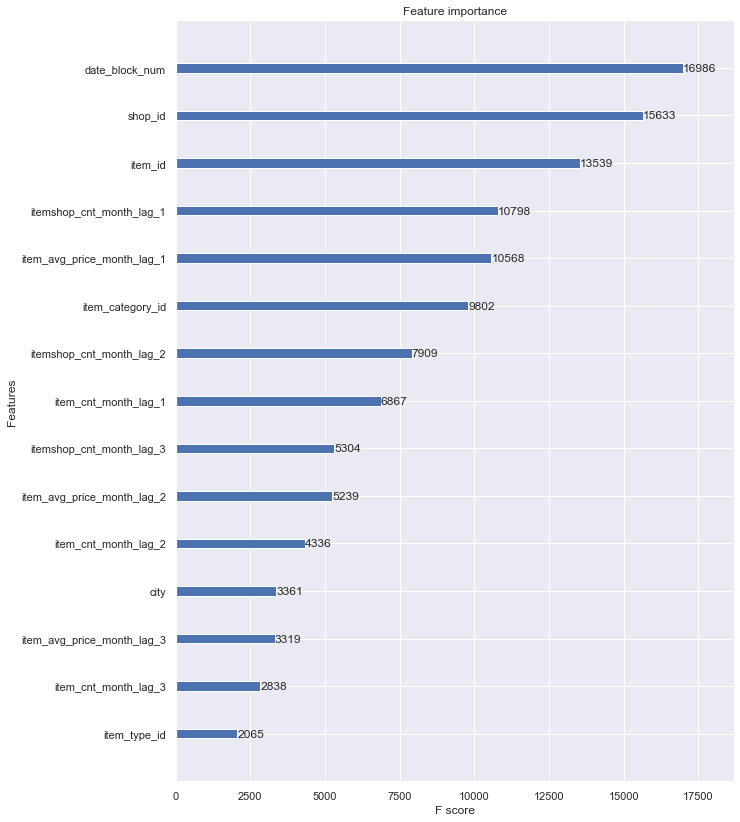

In [251]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))


In [245]:
X_test['pred'] = Y_test

In [247]:
df5 = df5.merge(X_test[['shop_id', 'item_id', 'pred']], on=['shop_id', 'item_id'])

In [250]:
submission = pd.DataFrame({'ID': df5.index,
                          'item_cnt_month': df5.pred.values})
submission.to_csv('submission4.csv', index=False)